# Machine Learning Project Report - Speech Sentiment Analysis

- We explore sentiment analysis in womens' speech for the following sentiments:
  - anger
  - fear
  - happiness
  - sadness
  - neutral

- We extract features from the audio files with the help of `librosa`:
  - `mfcc`
  - `mel`
  - `rms`
  - `spce`
  - `zcr`

- The classifiers tuned and trained were:
  - `SVM`
  - `KNN`

- Datasets:
  - [TESS](https://www.kaggle.com/datasets/ejlok1/toronto-emotional-speech-set-tess)
  - [Ravdess](https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio)

### Pre-Processing

- We have created a base abstract class called `DatasetParser`. This class handles:
  - Feature extraction (implements the way features are extracted with librosa)
  - Provides dynamic feature extraction (with the use of a list, we define which features to extract)
  - `FEATURES = [
      'mfcc',
      'mel',
      'rms',
      'spce',
      'zcr',
    ]`
  - We pad the extracted features to ensure same array size for each feature
  - Exports waveplots and spectrograms
  - Exports final `CSV`s with features
  - Scales our features using `StandardScaler`

In [9]:
'''
We have implemented 2 child classes (Ravdess and Toronto) with `DatasetParser` as the base class

These subclasses define their own way of parsing as the original datasets are different.

This is defined through the `parse` method (defined as abstract in parent class).
'''
import pandas as pd
import time
from parsers.ravdess import RavdessParser
from parsers.toronto import TorontoParser

ravdess_path = 'parsers/datasets/ravdess'
toronto_path = 'parsers/datasets/toronto'

ravdess = RavdessParser(ravdess_path)
toronto = TorontoParser(toronto_path)

In [4]:
import numpy as np
import librosa

'''
During feature extraction, along with the original data and features we extract using librosa,
we enhance the dataset with extra data using the following methods
'''
def noise(y):
    noise_amp = 0.010 * np.random.uniform() * np.amax(y)
    return (y + noise_amp * np.random.normal(size=y.shape[0]))

def stretch(y):
    return librosa.effects.time_stretch(y=y, rate=0.85)

'''
Pitch shift has been used during the analysis, but, not in the final datasets created
as we noticed a fair decrease in model training accuracy.
'''
def pitch_shift(y, sr):
    return librosa.effects.pitch_shift(y=y, sr=sr, n_steps=0.7)

In [10]:
# Defining important paths for TESS
toronto_export = f'./parsers/datasets/toronto.csv'
toronto_features = f'./parsers/datasets/toronto_features.csv'
toronto_dist = f'./plots/toronto_waveplots.png'
toronto_spec = f'./plots/toronto_spectrograms.png'

# Defining important paths for Ravdess
ravdess_export = f'./parsers/datasets/ravdess.csv'
ravdess_features = f'./parsers/datasets/ravdess_features.csv'
ravdess_dist = f'./plots/ravdess_waveplots.png'
ravdess_spec = f'./plots/ravdess_spectrograms.png'

### TESS Feature extraction
- We export for a random sample out of each class the waveforms and spectrograms (both mel and chroma)
- Using this visual representation, we get a sense of how similar or disimilar certain sentiments are (for instance neatral seems quite similar with lots of other labels)

Total runtime (toronto): 140.65s


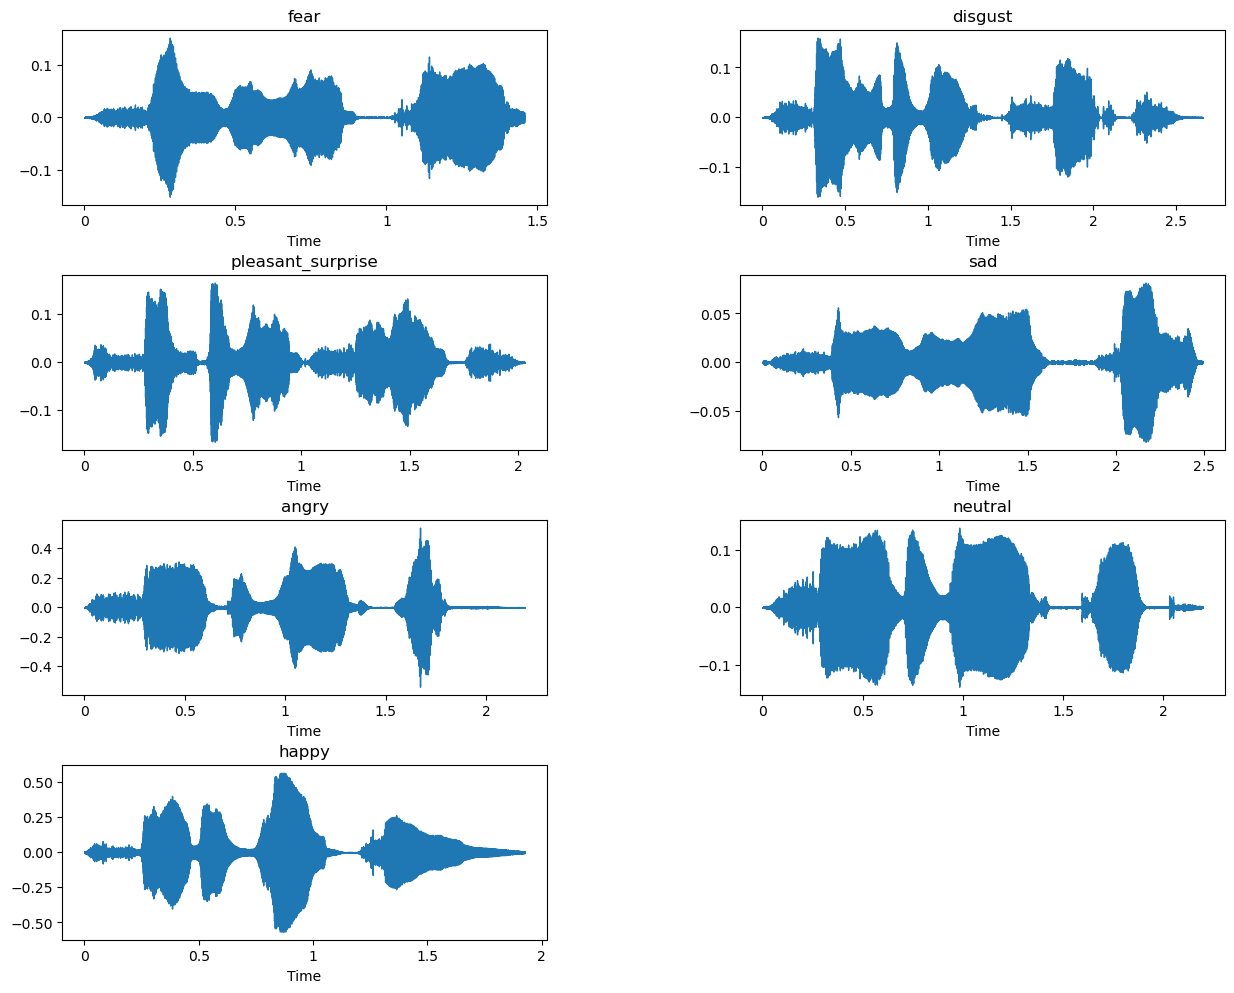

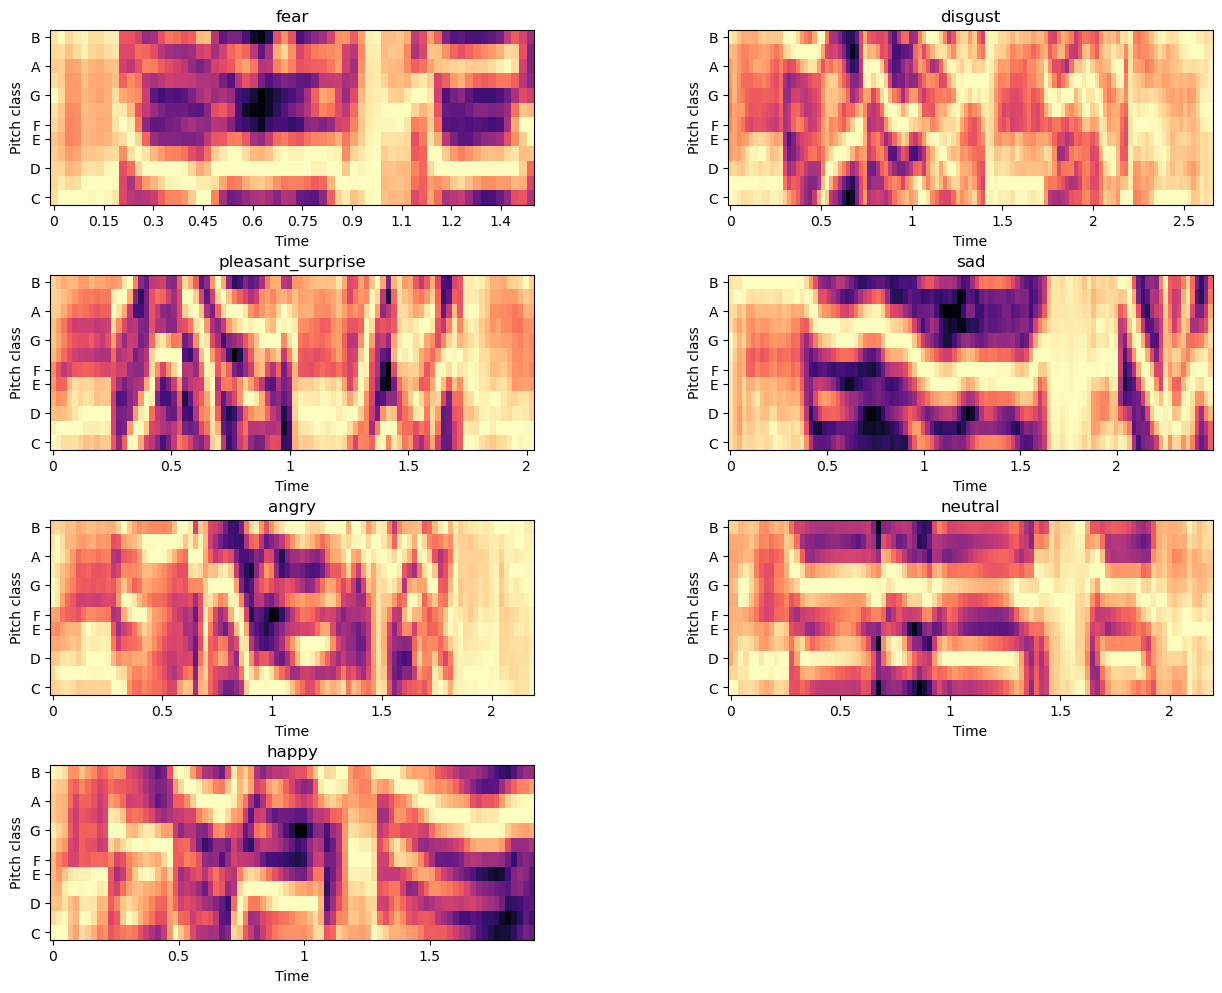

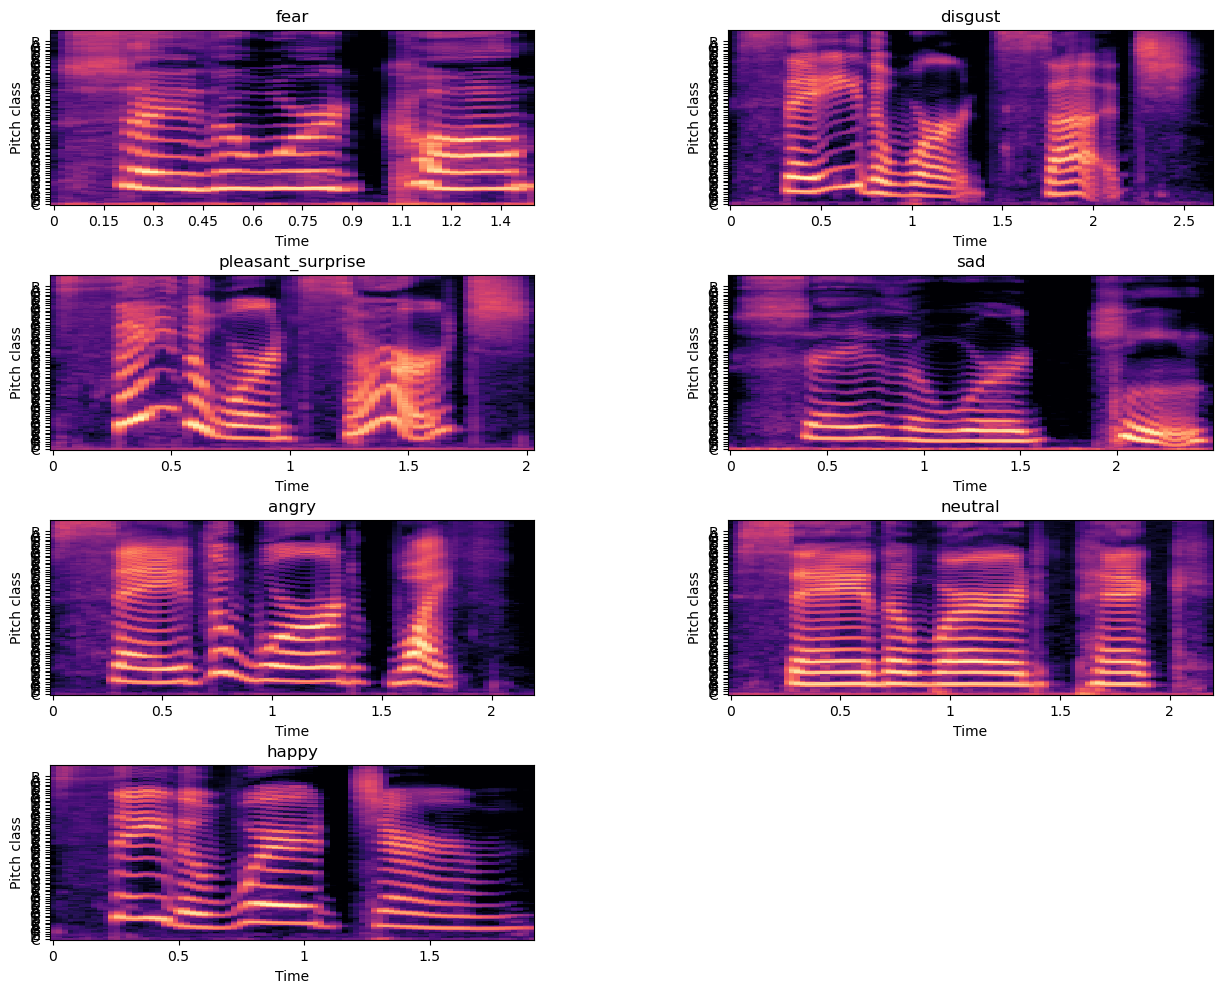

In [11]:
# Toronto extraction
start = time.time()
toronto \
    .parse() \
    .extract_features() \
    .waveplots(toronto_dist) \
    .spectrograms(toronto_spec) \
    .post_processing() \
    .post_process_extras() \
    .export(toronto_export, 'dataset') \
    .export(toronto_features)
end = time.time()

print(f'Total runtime (toronto): {(end - start):0.2f}s')
del toronto

### Ravdess Feature extraction
- We perform same process for ravdess dataset
- We noticed that already most of the visual representations have differences with `TESS` dataset
- In this case, `angry` and `disgust` seem to share quite a bit of similarirties judging from the visual representation, something that could affect the model training a lot
- The above lead to our decision to be one of the sentiments that we will exclude from the context of this project

Total runtime (ravdess): 103.65s


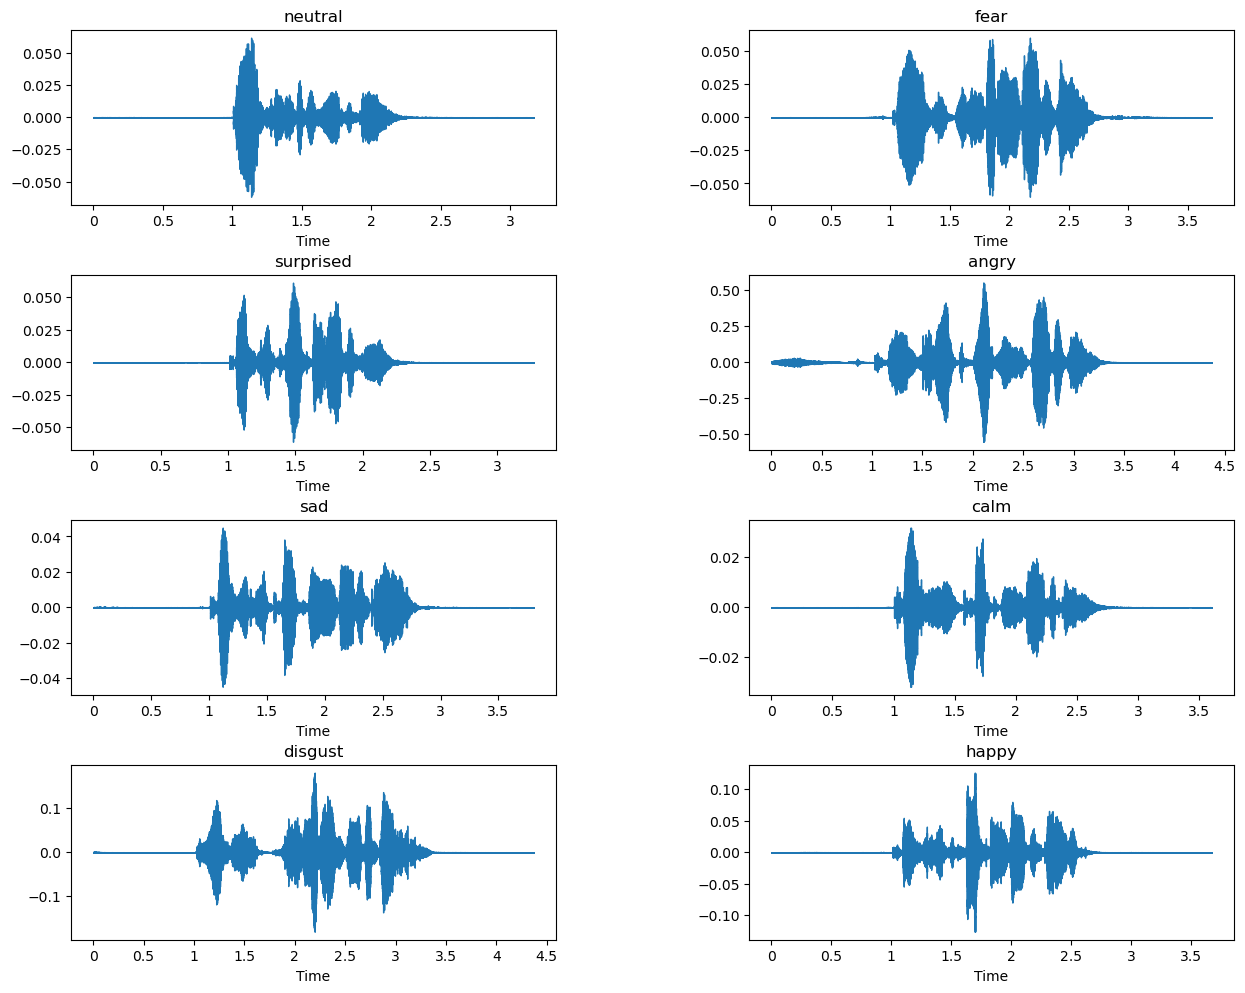

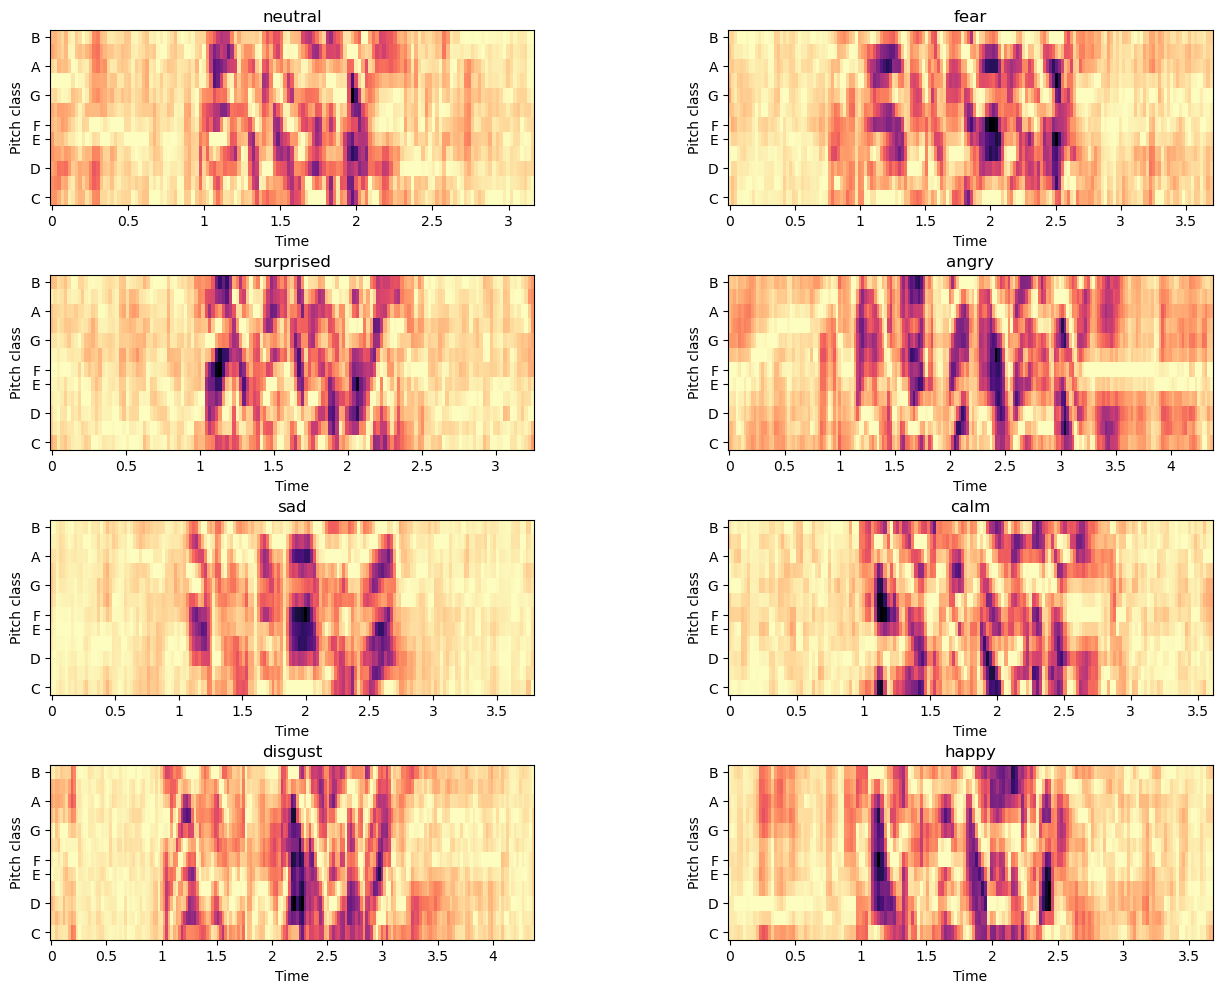

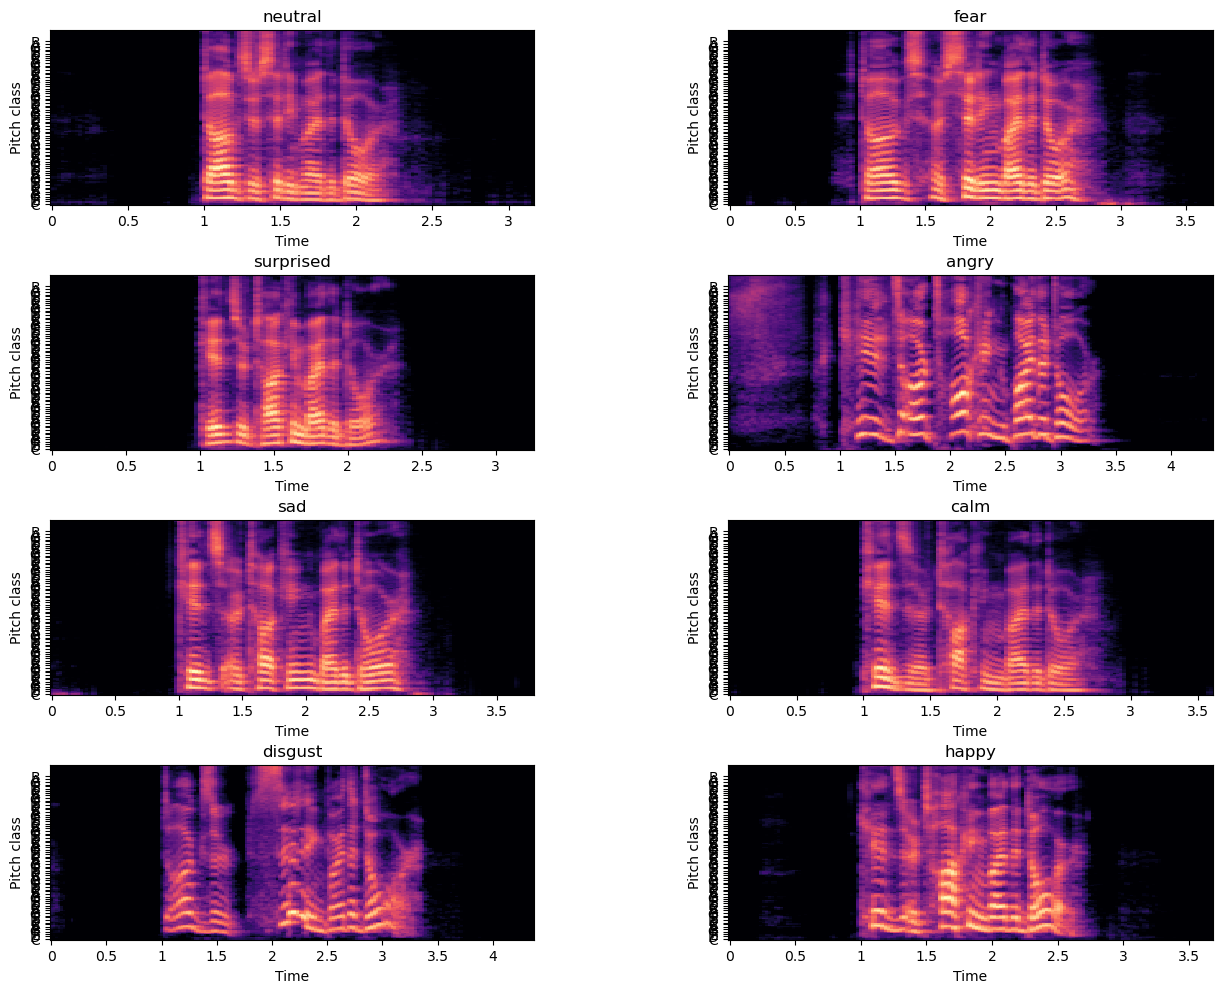

In [12]:
# Ravdess extraction
start = time.time()
ravdess \
    .parse() \
    .extract_features() \
    .waveplots(ravdess_dist) \
    .spectrograms(ravdess_spec) \
    .post_processing() \
    .post_process_extras() \
    .export(ravdess_export, 'dataset') \
    .export(ravdess_features)
end = time.time()

print(f'Total runtime (ravdess): {(end - start):0.2f}s')
del ravdess

### Split to training and test datasets
- We totally excluded some actors (`ravdess`) and the old woman (`TESS`) from the training dataset.
- If we had included even a small part from their `wav` files, that would be cheating in the model training.
- That means our test data will comprise of `wav` files from people that our training will know nothing about.

In [17]:
# Required for merging the datasets
SPLIT_RATIO = 0.1


def sample_sentiments(df, ratio=None):
    frac = ratio if ratio is not None else SPLIT_RATIO
    return df.groupby(['label', 'type']).sample(
        frac=frac,
        random_state=42
    )

# Parse the files extracted containing the features
toronto_df = pd.read_csv(toronto_features)
ravdess_df = pd.read_csv(ravdess_features)

# Keep onyl the sentiments we will work on
sentiments = [
    'angry',
    'fear',
    'happy',
    'neutral',
    'sad',
]

toronto_df = toronto_df[toronto_df['label'].isin(sentiments)]
ravdess_df = ravdess_df[ravdess_df['label'].isin(sentiments)]

# Start splitting the datasets to train and test

# Starting with training
# We keep only the young woman from TESS
toronto_sampled = toronto_df[toronto_df['age'] == 'Y']
# keep ratios per actor
toronto_sampled = sample_sentiments(toronto_sampled, 0.1)
toronto_sampled = toronto_sampled.drop(columns=[
    'age',
    'type'
])
# We keep only actors 1 through 20 for training
ravdess_sampled = ravdess_df[ravdess_df['actor'] <= 20]
ravdess_sampled = ravdess_sampled.drop(columns=[
    'actor',
    'gender',
    'type'
])
training_df = pd.concat([toronto_sampled, ravdess_sampled])

In [16]:
# Now we start creating the test dataset using what's left
# From the TESS data we include the old woman
toronto_rest = toronto_df[(toronto_df['age'] == 'O') &
                            (toronto_df['type'] == 'original')]
# keep ratios per actor
toronto_rest = sample_sentiments(toronto_rest, 0.03)
toronto_rest = toronto_rest.drop(columns=[
    'age',
    'type'
])
# From Ravdess, we include actors 21 through to 24
ravdess_rest = ravdess_df[(ravdess_df['actor'] > 20) &
                            (ravdess_df['gender'] == 'F') &
                            (ravdess_df['type'] == 'original')]
ravdess_rest = ravdess_rest.drop(columns=[
    'actor',
    'gender',
    'type'
])
test_df = pd.concat([toronto_rest, ravdess_rest])

In [20]:
training_df.head()

,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,...,mel_123,mel_124,mel_125,mel_126,mel_127,mel_128,rms_1,spce_1,zcr_1,label
3286,2.035475,-1.680524,-0.546978,-0.278676,-0.886623,-1.104837,1.518236,-0.543776,0.655777,0.306261,...,2.959202,2.257147,2.236023,2.826204,3.160298,3.903274,1.648722,2.163104,2.022728,angry
3046,2.624277,-1.548306,0.099298,1.097928,-0.187686,-0.933291,1.598017,-0.648564,0.577073,-0.313428,...,4.667169,6.631150,6.855133,4.622594,3.968052,7.484497,3.423905,1.793558,1.018959,angry
3091,2.409290,-0.433226,-0.146781,-0.883895,-1.484045,-0.776666,1.023895,-1.132282,1.360445,0.077383,...,13.179024,9.443675,5.695332,4.303714,3.614732,3.765141,4.138363,0.974278,0.823918,angry
3475,0.463659,-1.736537,-0.144232,0.586720,-1.536232,0.046673,1.498327,-0.670679,1.034770,-0.167498,...,0.906247,1.072721,1.420150,1.494974,1.403448,0.773933,0.343814,1.723382,1.332444,angry
3385,1.739101,-1.825618,-0.091005,0.269346,-0.706626,-0.923188,1.088975,-0.533095,0.579482,-1.074352,...,1.142977,1.032474,1.475553,2.343803,2.292749,3.478275,0.582905,2.336814,2.102795,angry


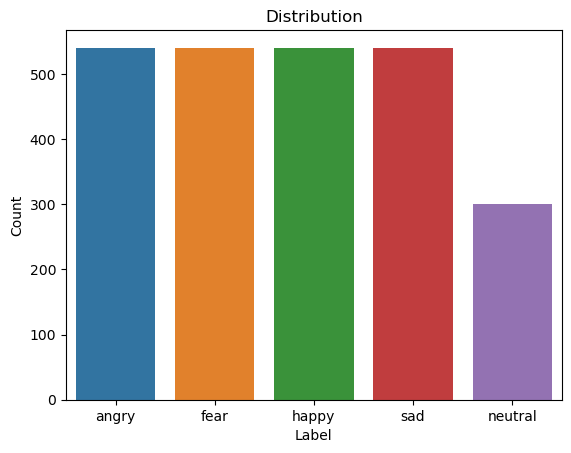

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

def label_dist(df):
    sns.countplot(
        x='label',
        data=df,
        order=df['label'].value_counts().index
    )
    plt.title('Distribution')
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.show()

label_dist(training_df)

### Feature Engineering
- Having finalized our training and test datasets we move on to feature engineering
- We employed 3 different measures to try and get a better view of our features and which of them are important
- `LabelEncoder` is used to convert categorical text labels into numerical form. This transformation is crucial because most machine learning models and algorithms require input to be numeric. `OneHotEncoder` could also be utilized. Both will work in our use case.

In [40]:
from sklearn.preprocessing import LabelEncoder

df = training_df.copy(deep=True)
X = df.drop('label', axis=1)
y = df['label']

# Create a label encoder object
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

### PCA
- This is one of the processes we explored to visualize the most important features. However, it didn't yield very good results as most of the labels seems to be overlapping for the top 3 principal components

![PCA_1](./feature_engineering/pca_01.png)
![PCA_2](./feature_engineering/pca_02.png)

### RFE
- We proceeded with Recursive Feature Elimination (`RFE`) which is a feature selection technique that works by recursively removing features, building a model using the remaining attributes, and calculating model accuracy.
- Initially, RFE trains a model (often a `linear` model) and assigns weights to each feature; features with the smallest weights are deemed least important and are removed. This process is repeated until a specified number of features remains.
- Despite being mainly used with `linear` models, the results can still be beneficial for non-linear models, such as in our case where Radial Basis Function (`RBF`) kernel was used.
- We executed `RFE` by testing all top `X` features, starting with `5` and moving on with a step size of `5`.
- We then plotted all the average accuracies and `std`s for each run of the process.
- Finally, we selected and exported the top `155` features as they had the best average accuracy with the smallest deviation.
- Although the results were in general okay (`KNN` was reporting better results in validation), we decided to go through with the next process, which is the use of `RandomForests` classifier to retrieve the feature importances. The features extracted from this process yielded better results all in all.

![RFE box plot](./feature_engineering/box_plot_rfe.png)

### Feature importance with RandomForest Classifier
- We retrieved all the features whose importance was greater than the (`mean`+ `std`) of all importances.
- We saved those features in a `pickle` file for use in model training.

Total runtime for model training: 0.93s
Accuracy: 0.829
Elapsed time to compute the importances: 0.00s


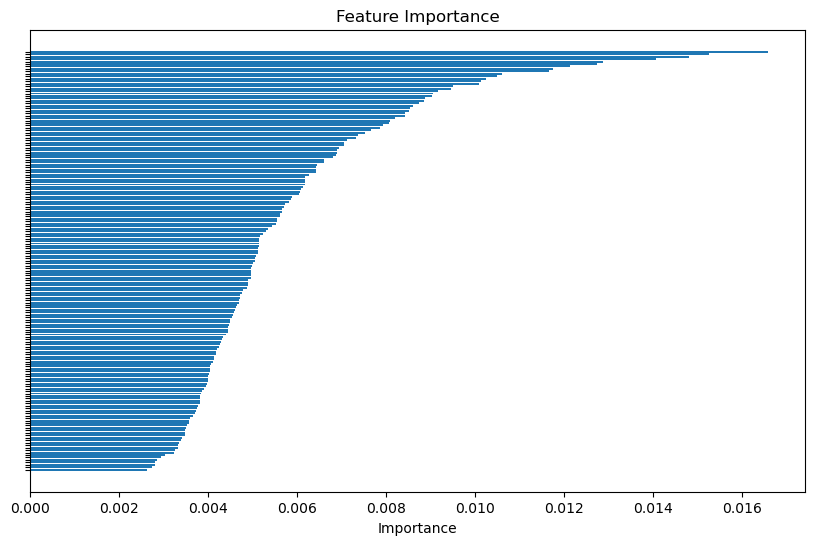

In [65]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

def get_color(lbl):
    return {
        'fear': 'red',
        'disgust': 'blue',
        'pleasant_surprise': 'green',
        'sad': 'yellow',
        'angry': 'purple',
        'neutral': 'orange',
        'happy': 'pink'
    }[lbl]


df = training_df.copy(deep=True)

# feature matrix
X = df.drop('label', axis=1)
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42
)

# Model training
start = time.time()

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

end = time.time()
print(f"Total runtime for model training: {(end - start):0.2f}s")

# Accuracy
y_pred = clf.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred):0.3f}')

# Compute importances
start = time.time()

importances = clf.feature_importances_

end = time.time()
print(f"Elapsed time to compute the importances: {(end - start):0.2f}s")

# Create a DataFrame for visualization
features = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

bound = np.mean(importances) - np.std(importances)

labels = features[features['Importance'] >= bound]['Feature'].tolist()

plt.figure(figsize=(10, 6))
plt.barh(features['Feature'], features['Importance'])
plt.xlabel('Importance')
plt.yticks(visible=False)
plt.title('Feature Importance')
# Invert y-axis to have the most important feature on top
plt.gca().invert_yaxis()
plt.show()

### SVM tuning
- `GridSearchCV` was utilized to optimize the `SVM` hyperparameters.
- Based on what we have concluded from the analysis up till now, we decided to make the margins a bit tighter (that's why we search for `C` values within `[1,3]`)
- We checked for an appropriate value of `gamma` that would range approximately from `1/n_features` with an increased upper limit

In [66]:
import pickle
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

pickle_feat_path = './feature_engineering/selected_features_rfc.pickle'
with open(pickle_feat_path, 'rb') as file:
    # Load the features from the pickle file
    features_selected = pickle.load(file)

X = df.drop('label', axis=1)
labels = df['label']

# Create a label encoder object
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)

# Keep only selected features from feature importance
X = X.loc[:, features_selected]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

# Create a pipeline that standardizes data then applies SVM
pipeline = make_pipeline(SVC(kernel='rbf'))

# Define parameter grid
param_grid = {
    'svc__C': np.arange(1, 3.1, 0.5),
    'svc__gamma': np.arange(0.007, 0.011, 0.001)
}

# Grid search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

Best parameters: {'svc__C': 3.0, 'svc__gamma': 0.01}
Best cross-validation score: 0.8099507885457434


### SVM
- We used the hyperparameters chosen by the `SVM` tuning
- We plot confusion matrix and ROC
- We export the model using `joblib` in order to be used by our demo

SVM model trained in: 1.18s
C: 3
Gamma: 0.01
Accuracy: 0.833
Precision: 0.846
Recall: 0.823
F1: 0.829
Matthews Correlation Coefficient: 0.791


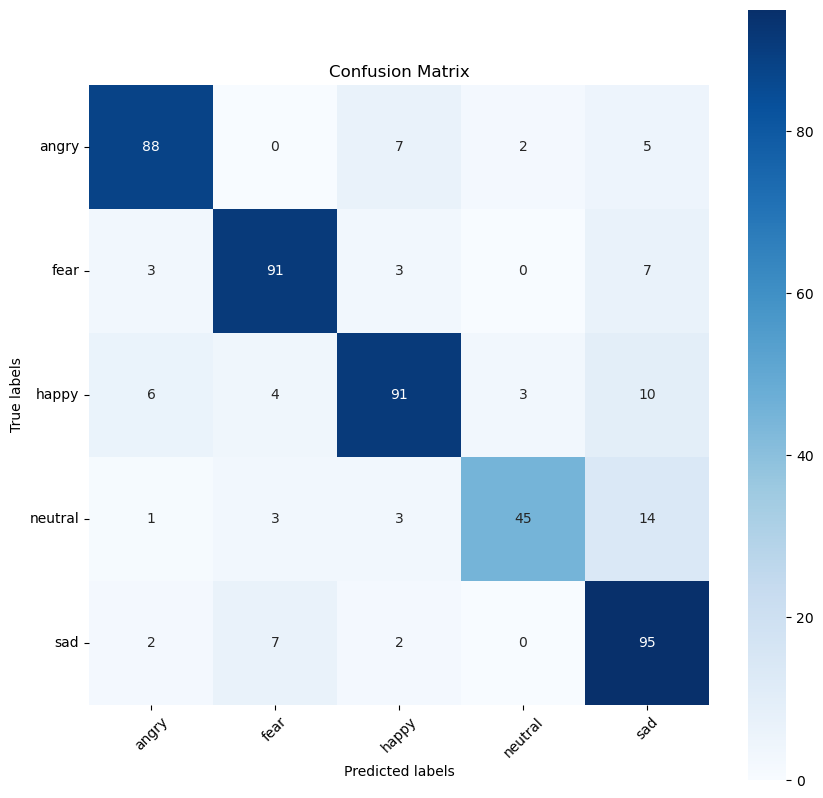

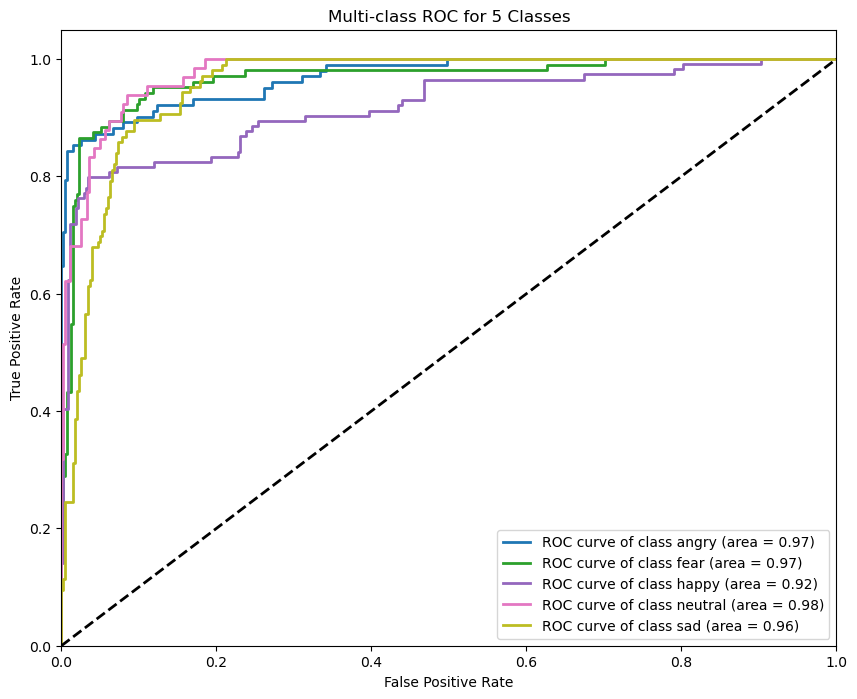

In [67]:
from sklearn.metrics import (
    accuracy_score, auc,
    confusion_matrix, f1_score,
    matthews_corrcoef, precision_score,
    recall_score, roc_curve
)
from sklearn.preprocessing import label_binarize

def plot_cm(cm, labels):
    # Create a heatmap
    fig, ax = plt.subplots(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, square=True,
                xticklabels=np.unique(labels), yticklabels=np.unique(labels))

    # Labels, title, and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(np.unique(labels))
    ax.xaxis.set_tick_params(rotation=45)
    ax.yaxis.set_ticklabels(np.unique(labels))
    ax.yaxis.set_tick_params(rotation=0)
    plt.show()

def plot_roc(y, y_test, y_score, labels):
    n_classes = len(np.unique(y))
    y_test = label_binarize(y_test, classes=np.unique(y))

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Colors for the ROC curves
    # Choose a colormap
    colormap = plt.get_cmap('tab20')

    # Generate colors from the colormap
    colors = [colormap(i / n_classes) for i in range(n_classes)]

    # Plot all ROC curves
    plt.figure(figsize=(10, 8))

    for i, color in zip(range(n_classes), colors):
        plt.plot(
            fpr[i],
            tpr[i],
            color=color,
            lw=2,
            label='ROC curve of class {0} (area = {1:0.2f})'.format(
                labels[i], roc_auc[i]
            )
        )
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-class ROC for {0} Classes'.format(n_classes))
    plt.legend(loc="lower right")
    plt.show()


# breakdown to train/validation
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

start = time.time()

C = 3
gamma = 0.01
svm = SVC(
    C=C,
    kernel='rbf',
    gamma=gamma,
    probability=True,
    random_state=42,
    cache_size=800
)

fitted = svm.fit(X_train, y_train)

end = time.time()
print(f'SVM model trained in: {(end - start):0.2f}s')

y_score = fitted.decision_function(X_test)
y_pred = svm.predict(X_test)

# METRICS
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
matthews = matthews_corrcoef(y_test, y_pred)

print(f'C: {C}')
print(f'Gamma: {gamma}')
print(f'Accuracy: {accuracy:0.3f}')
print(f'Precision: {precision:0.3f}')
print(f'Recall: {recall:0.3f}')
print(f'F1: {f1:0.3f}')
print(f'Matthews Correlation Coefficient: {matthews:0.3f}')

cm = confusion_matrix(y_test, y_pred)
plot_cm(cm, labels)

plot_roc(y, y_test, y_score, np.unique(labels))

### KNN
- We utilize the square root of the features used in the training for the number of neighbors
- We use the Minkowski distance metric
- We export the trained model using `joblib` for use by the demo

KNN model trained in: 0.00s
Accuracy: 0.717
precision: 0.718
recall: 0.718
f1: 0.714
Matthews Correlation Coefficient: 0.647


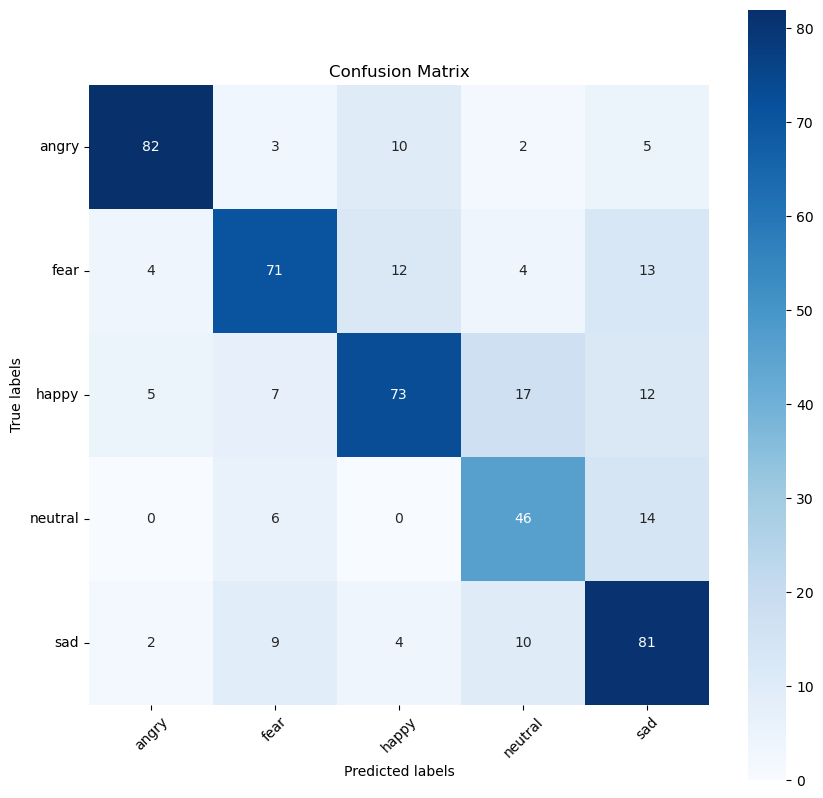

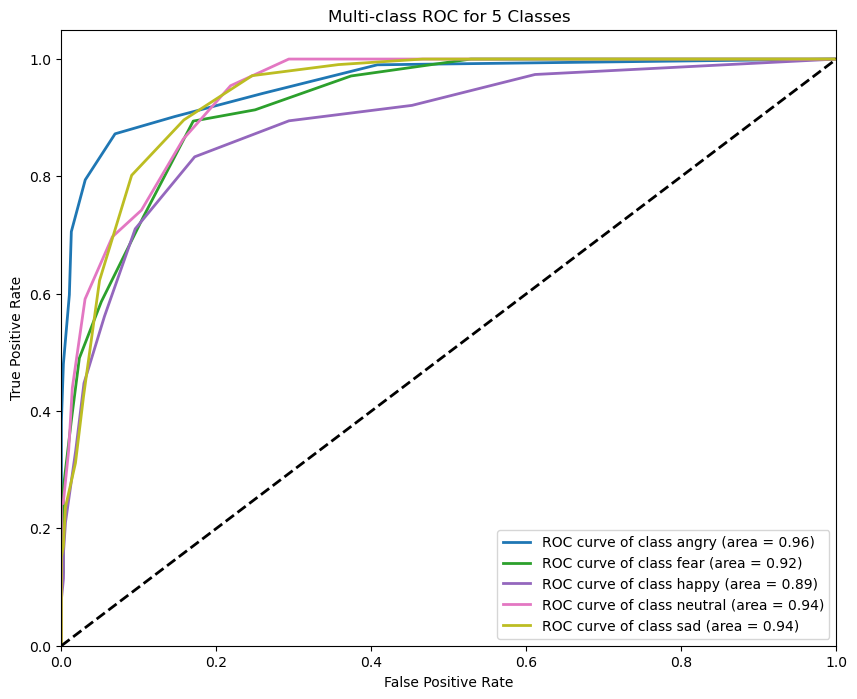

In [68]:
import math
from sklearn.neighbors import KNeighborsClassifier


def get_neighbors(number):
    return round(math.sqrt(number))

# breakdown to train/validation
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

start = time.time()

knn = KNeighborsClassifier(
    n_neighbors=get_neighbors(X.shape[1]),
    p=1,
)

knn.fit(X_train, y_train)

end = time.time()
print(f'KNN model trained in: {(end - start):0.2f}s')

y_score = knn.predict_proba(X_test)
y_pred = knn.predict(X_test)


# METRICS
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
matthews = matthews_corrcoef(y_test, y_pred)

print(f'Accuracy: {accuracy:0.3f}')
print(f'precision: {precision:0.3f}')
print(f'recall: {recall:0.3f}')
print(f'f1: {f1:0.3f}')
print(f'Matthews Correlation Coefficient: {matthews:0.3f}')

cm = confusion_matrix(y_test, y_pred)
plot_cm(cm, labels)

plot_roc(y, y_test, y_score, np.unique(labels))

### Demo
- We filter our test dataset with the selected features (loaded via `pickle`)
- We load the 2 models `SVM` and `KNN`
- We export metrics and confusion matrix

In [6]:
import pandas as pd
import pickle
from sklearn.preprocessing import LabelEncoder

test_df = pd.read_csv('./parsers/datasets/test.csv')
X = test_df.drop('label', axis=1)
labels = test_df['label']

# Create a label encoder object
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)

pickle_feat_path = './feature_engineering/selected_features_rfc.pickle'

with open(pickle_feat_path, 'rb') as file:
    # Load the array from the pickle file
    features_selected = pickle.load(file)

# Use only labels coming from RFE feature selection
X = X.loc[:, features_selected]

In [8]:
from joblib import load
from sklearn.metrics import (
    accuracy_score, confusion_matrix,
    f1_score, matthews_corrcoef,
    precision_score, recall_score
)

# Loading the model from disk
svm_model = load('./models/svm.joblib')
knn_model = load('./models/knn.joblib')

y_pred_svm = svm_model.predict(X)
y_pred_knn = knn_model.predict(X)

accuracy_svm = accuracy_score(y, y_pred_svm)
accuracy_knn = accuracy_score(y, y_pred_knn)
precision_svm = precision_score(y, y_pred_svm, average='macro')
precision_knn = precision_score(y, y_pred_knn, average='macro')
recall_svm = recall_score(y, y_pred_svm, average='macro')
recall_knn = recall_score(y, y_pred_knn, average='macro')
f1_svm = f1_score(y, y_pred_svm, average='macro')
f1_knn = f1_score(y, y_pred_knn, average='macro')
matthews_svm = matthews_corrcoef(y, y_pred_svm)
matthews_knn = matthews_corrcoef(y, y_pred_knn)

print(f"Model accuracy SVM: {accuracy_svm:.3f}")
print(f"Model accuracy KNN: {accuracy_knn:.3f}")
print(f'Precision SVM: {precision_svm:0.3f}')
print(f'Precision KNN: {precision_knn:0.3f}')
print(f'Recall SVM: {recall_svm:0.3f}')
print(f'Recall KNN: {recall_knn:0.3f}')
print(f'F1 SVM: {f1_svm:0.3f}')
print(f'F1 KNN: {f1_knn:0.3f}')
print(f'Matthews Correlation Coefficient SVM: {matthews_svm:0.3f}')
print(f'Matthews Correlation Coefficient KNN: {matthews_knn:0.3f}')

Model accuracy SVM: 0.637
Model accuracy KNN: 0.539
Precision SVM: 0.592
Precision KNN: 0.589
Recall SVM: 0.596
Recall KNN: 0.536
F1 SVM: 0.577
F1 KNN: 0.532
Matthews Correlation Coefficient SVM: 0.548
Matthews Correlation Coefficient KNN: 0.433


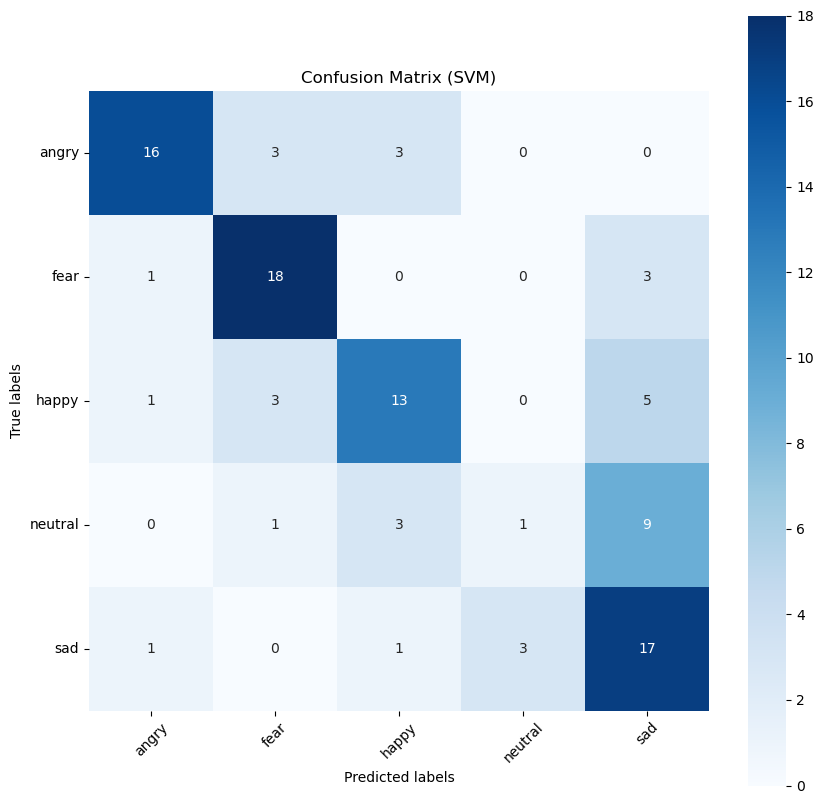

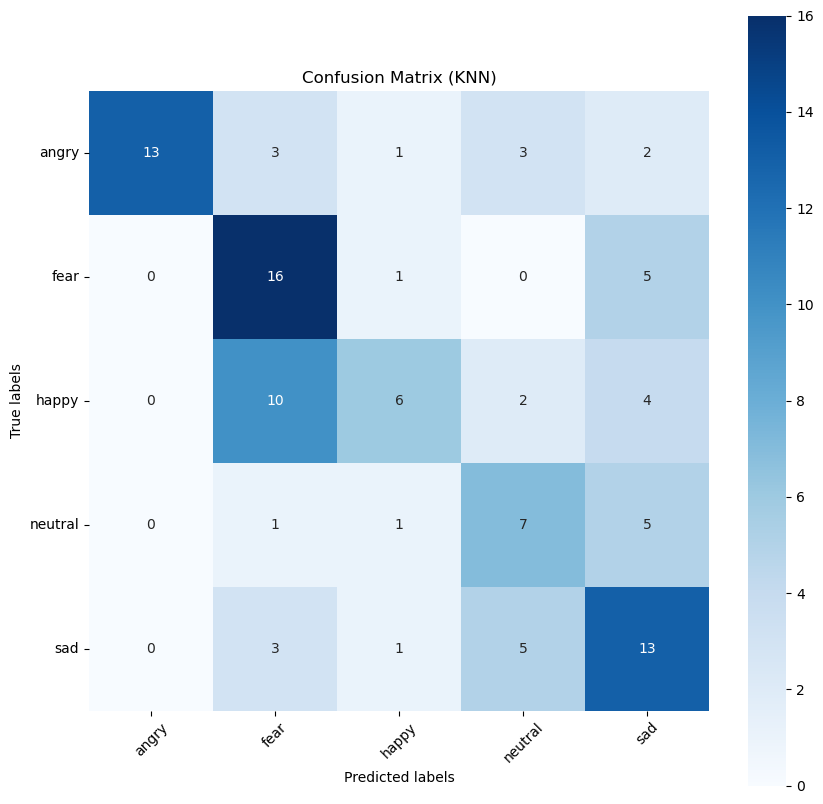

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_cm(cm, labels, model):
    # Create a heatmap
    fig, ax = plt.subplots(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, square=True,
                xticklabels=np.unique(labels), yticklabels=np.unique(labels))

    # Labels, title, and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title(f'Confusion Matrix {model}')
    ax.xaxis.set_ticklabels(np.unique(labels))
    ax.xaxis.set_tick_params(rotation=45)
    ax.yaxis.set_ticklabels(np.unique(labels))
    ax.yaxis.set_tick_params(rotation=0)
    plt.show()

cm_svm = confusion_matrix(y, y_pred_svm)
plot_cm(cm_svm, labels, '(SVM)')

cm_knn = confusion_matrix(y, y_pred_knn)
plot_cm(cm_knn, labels, '(KNN)')

### Conclusions
- `SVM` was chosen over `KNN` because in the ROC plots, the curves suggested that for each class, `SVM` classifier could achieve a higher true positive rate while still maintaining a low false positive rate as the discrimination threshold is varied, which is desirable in a classification system.
- `Neutral` sentiment performed poorly in both training and test data. The reason for this seems to be the imbalance in the training dataset.
- Low accuracy on the test data was expected, as it's `wav`s with people whose voice the classifiers were never trained with and remained completely out of the model training.